## Dota 2 international statistics

This is a fun project that I built, my objective is to understand the most important characteristics and performance statistic of a team that won a Dota 2 International math!

Dota 2 is a popular multiplayer online battle arena (MOBA) game. Players control a powerful character, called a "hero", and work with a team to defeat the other team's heroes. The game is set on a virtual battlefield and players use different strategies and abilities to defeat the enemy team. It is a very popular e-sport game, with many professional players and tournaments with large prize pools.

The International is an annual esports tournament for Dota 2. It is organized and produced by Valve, the company that developed Dota 2. The tournament features teams from around the world competing for a large prize pool, which is crowdfunded by the Dota 2 community through the sale of in-game items. The International is considered the most prestigious tournament in the Dota 2 professional scene and is often referred to as the "World Championship" of Dota 2. It is also one of the largest esports tournaments in terms of prize pool, with the total prize money for the tournament often surpassing tens of millions of dollars.

The notebook uses a dataset from the Dota 2 open api which contains information about matches, leagues, players and much more. Using this data we build an XGBoost model to predict if a player’s team will win based off statistics of how that player played the match.

In [24]:
import requests
import pandas as pd
import numpy as np
import itertools
import os


from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from timeit import default_timer as timer

pd.set_option('display.max_columns', None)

The Dota api is very simple, the steps that I will perform are:

- Get a list of all dota 2 league events
- Look for leagues named international and return to a list 
- Get all matches from the international
- Save in a dataframe all players status from those matches


In [2]:
# Function that returns a series of ids from dota 2 leagues filtered by a string
def league_match_id(league_str):
    leagues = pd.DataFrame(requests.get("https://api.opendota.com/api/leagues").json())
    # upper strings for better filtering
    leagues.name = leagues.name.str.upper()
    league_id = leagues.loc[leagues.name.str.find(league_str) > 0]
    return league_id

In [3]:
# With the league ids, this function returns a series of match ids from leagues
def league_matches(league_id):
    match_id = []
    for i in league_id:
        try:
            match_id.append(pd.DataFrame(requests.get("https://api.opendota.com/api/leagues/{}/matches".format(i)).json()).match_id)
        except:
            pass
    return list(itertools.chain(*match_id))

In [4]:
# Returns a dataframe with statistics of players in matches, require the ids of matches
def players_stats_match(league_matches_id):
    players_df = pd.DataFrame(requests.get("https://api.opendota.com/api/matches/{}".format(league_matches_id[0])).json()['players'])
    for i in league_matches_id[1:]:
        try:
            aux = pd.DataFrame(requests.get("https://api.opendota.com/api/matches/{}".format(i)).json()['players'])
            players_df = pd.concat([players_df,aux])
        except:
            pass
    return players_df
        

In [5]:
# Searching for "HE INTERNATIONAL"
league_id = league_match_id('HE INTERNATIONAL')

In [6]:
league_id 

,leagueid,ticket,banner,tier,name
568,5401,None,None,professional,THE INTERNATIONAL 2017
931,10049,None,None,excluded,THE INTERNATIONAL 2018 OPEN QUALIFIERS
1257,13256,None,None,premium,THE INTERNATIONAL 2021
1701,65005,econ/leagues/subscriptions_westqualifier_ingame,econ/leagues/subscriptions_westqualifier_ingame,professional,THE INTERNATIONAL WEST QUALIFIERS
1759,65004,econ/leagues/subscriptions_eastqualifier_ingame,econ/leagues/subscriptions_eastqualifier_ingame,professional,THE INTERNATIONAL EAST QUALIFIERS
2988,600,None,None,professional,THE INTERNATIONAL 2014
3425,10749,None,None,premium,THE INTERNATIONAL 2019
3640,2733,None,None,professional,THE INTERNATIONAL 2015
3777,4664,None,None,premium,THE INTERNATIONAL 2016
3779,4768,None,None,excluded,THE INTERNATIONAL 2016 OPEN QUALIFIERS


By searching for "HE INTERNATIONAL" I was able to find all international ids and some qualifiers as well!

In [7]:
# Get match ids from list of league ids
league_matches_id = league_matches(league_id.leagueid)

In [8]:
len(league_matches_id)

3841

After this process we end up with 3841 matches, 10+ years of International is almost 4k matches, thats incredible! 

In [9]:
%%time
# Lets get players data! This process takes some time
players_df = players_stats_match(league_matches_id)

In [1]:
players_df.head()

NameError: name 'players_df' is not defined

This is how our data is presented, each row represents the performance of a player in a certain match.

There is a lot of information, so I will narrow it down to the features that I considerate the most relevant, and I will not dig down on hero selection (even tho I think it is very important) because since we have 10+ years of games, the buffs and nerfs can result in an unreliable information

The features that I will use for this model are:

- camps_stacked
- deaths
- denies
- gold
- gold_per_min
- gold_spent
- hero_damage
- hero_healing
- kills
- last_hits
- level
- net_worth
- obs_placed
- pings
- rune_pickups
- teamfight_participation
- tower_damage
- xp_per_min
- kills_per_min
- neutral_kills
- buyback_count
- actions_per_min
- lane_efficiency
- win
- stuns


In [11]:
stats = players_df[['camps_stacked','deaths','denies','gold','gold_per_min','gold_spent','hero_damage','hero_healing','kills','last_hits','level','net_worth','obs_placed','pings','rune_pickups','teamfight_participation','tower_damage','xp_per_min','kills_per_min','neutral_kills','buyback_count','actions_per_min','lane_efficiency','win','stuns']]

In [12]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28350 entries, 0 to 9
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   camps_stacked            15393 non-null  object 
 1   deaths                   28350 non-null  int64  
 2   denies                   28350 non-null  int64  
 3   gold                     17460 non-null  object 
 4   gold_per_min             28350 non-null  int64  
 5   gold_spent               17460 non-null  object 
 6   hero_damage              17460 non-null  object 
 7   hero_healing             17460 non-null  object 
 8   kills                    28350 non-null  int64  
 9   last_hits                28350 non-null  int64  
 10  level                    28350 non-null  int64  
 11  net_worth                28350 non-null  int64  
 12  obs_placed               15393 non-null  object 
 13  pings                    17925 non-null  object 
 14  rune_pickups             1

There is alot of missing values and some strange data, I belive this is caused by the many versions of the game, new features and mechanics beeing added may cause some data inconsistency, so to avoid that I think the best option is just to drop all missing values and transform all data points to float

In [13]:
stats = stats.dropna().astype(float)

In [14]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13466 entries, 0 to 9
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   camps_stacked            13466 non-null  float64
 1   deaths                   13466 non-null  float64
 2   denies                   13466 non-null  float64
 3   gold                     13466 non-null  float64
 4   gold_per_min             13466 non-null  float64
 5   gold_spent               13466 non-null  float64
 6   hero_damage              13466 non-null  float64
 7   hero_healing             13466 non-null  float64
 8   kills                    13466 non-null  float64
 9   last_hits                13466 non-null  float64
 10  level                    13466 non-null  float64
 11  net_worth                13466 non-null  float64
 12  obs_placed               13466 non-null  float64
 13  pings                    13466 non-null  float64
 14  rune_pickups             1

This is how our final dotaset looks like, the pivot table below aggregate some values by win, win = 1 means that the team won and win = 0 is a loss

In [15]:
stats.pivot_table(columns = 'win',
              aggfunc = ['mean','min','max'])

mean                        min               \
win                               0.0           1.0          0.0          1.0   
actions_per_min            242.582436    255.844224     0.000000     0.000000   
buyback_count                0.798471      0.361588     0.000000     0.000000   
camps_stacked                1.445328      1.577321     0.000000     0.000000   
deaths                       6.445796      3.600000     0.000000     0.000000   
denies                       8.313212      8.909001     0.000000     0.000000   
gold                      1148.290906   2851.491850     0.000000     0.000000   
gold_per_min               393.800499    486.286464   136.000000   177.000000   
gold_spent               14595.346280  17169.674699  1940.000000  1650.000000   
hero_damage              16531.864608  19259.676683   926.000000  1426.000000   
hero_healing               837.973171   1267.005528     0.000000     0.000000   
kills                        4.055686      6.569100     1.000000     1.000000   
kills_per_min                0.097717      0.171123     0.009069     0.012215   
lane_efficiency              0.577648      0.598110     0.191188     0.191188   
last_hits                  204.204180    212.163572     2.000000     0.000000   
level                       18.767119     20.967116     5.000000     6.000000   
net_worth                13089.890969  17549.024947   673.000000  1687.000000   
neutral_kills               58.911402     67.873848     0.000000     0.000000   
obs_placed                   3.398846      3.497378     0.000000     0.000000   
pings                       55.775698     64.624380     1.000000     1.000000   
rune_pickups                 4.989237      6.515237     0.000000     0.000000   
stuns                       29.947653     32.145383   -16.726807   -19.569824   
teamfight_participation      0.645806      0.667331     0.100000     0.148148   
tower_damage              1046.399002   3740.223529     0.000000     0.000000   
xp_per_min                 447.468882    562.165840    62.000000   106.000000   

                                   max                 
win                                0.0            1.0  
actions_per_min             879.000000     889.000000  
buyback_count                 5.000000       5.000000  
camps_stacked                17.000000      15.000000  
deaths                       22.000000      19.000000  
denies                       73.000000      62.000000  
gold                      12625.000000   25301.000000  
gold_per_min               1140.000000    1260.000000  
gold_spent               119110.000000   85445.000000  
hero_damage              144394.000000  223054.000000  
hero_healing              62016.000000   49800.000000  
kills                        31.000000      27.000000  
kills_per_min                 0.579981       0.852273  
lane_efficiency               1.483023       1.568513  
last_hits                  1970.000000    1536.000000  
level                        30.000000      30.000000  
net_worth                 60922.000000   63220.000000  
neutral_kills               681.000000     492.000000  
obs_placed                   47.000000      43.000000  
pings                       611.000000     566.000000  
rune_pickups                 53.000000      40.000000  
stuns                       405.287570     447.589900  
teamfight_participation       1.333333       1.047619  
tower_damage              37504.000000   40709.000000  
xp_per_min                 1028.000000    1204.000000

## Model Training

So now lets train our XGBoost model

In [16]:
X = stats.drop(['win'], axis = 1)
y = stats['win']

In [17]:
Xt, Xv, yt, yv = train_test_split(X,y, test_size=0.2, random_state=10)

In [18]:
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

In [19]:
params = {
    "eta": 0.5,
    "max_depth": 4,
    "objective": "binary:logistic",
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 3, [(dt, "train"), (dv, "valid")], early_stopping_rounds=5, verbose_eval=25)

[0]	train-logloss:0.52191	valid-logloss:0.52965
[2]	train-logloss:0.38232	valid-logloss:0.40677


Pass `evals` as keyword args.


In [20]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

## Explain a single player’s chances of winning a particular match

SHAP values sum to the difference between the expected output of the model and the current output for the current player. This means that the units of the SHAP values for this model are log odds ratios. Large positive values mean a player is likely to win, while large negative values mean they are likely to lose.

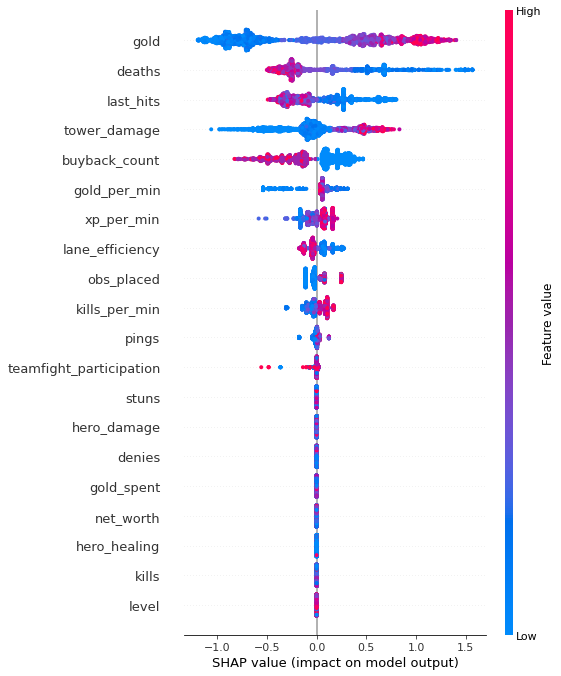

In [21]:
shap.summary_plot(shap_values, Xv)

A SHAP value tells us how much a certain feature affects a model's prediction. The plot shows the SHAP values for one feature like deaths on the x-axis. By looking at the plot for all the features, we can see which features have a big impact on the prediction like gold and which have a small impact like kills. The dots on the plot are also color-coded to show how the feature's value affects the prediction

## Prediction change by each feature

The XGBoost model is complicated, but by looking at how a feature's value affects the model's output, we can see how changes in the feature's value affect the prediction. The plot is similar to a standard plot, but it also shows how the context of other features affects the importance of the feature. The vertical spread of the data points shows how much other features affect how much the feature matters. For example, earning 100 gold/min may lower the odds of winning by 10 for some players and only 3 for others. The plot also shows that the importance of other features decreases as a player earns more gold. The y-axis shows the SHAP value for the feature, a value of -4 means that the feature lowers the odds of winning by 4 and a value of +2 means that it raises the odds of winning by 2. It's important to note that these plots only show how the XGBoost model works, not necessarily how reality works. The model is based on observational data and is not necessarily a causal model, meaning that just because a factor makes the model's prediction of winning go up, it doesn't always mean it will raise your actual chances.

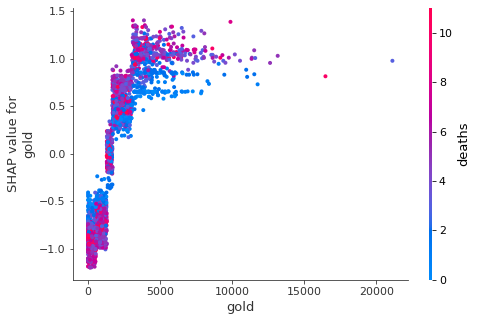

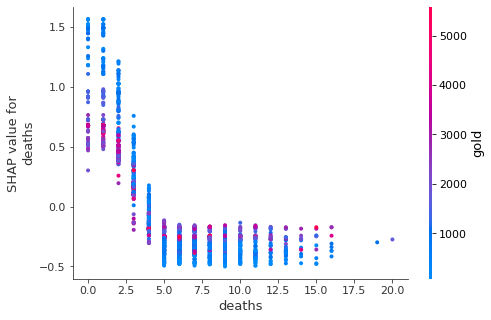

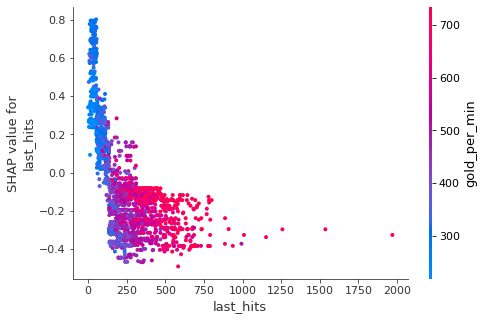

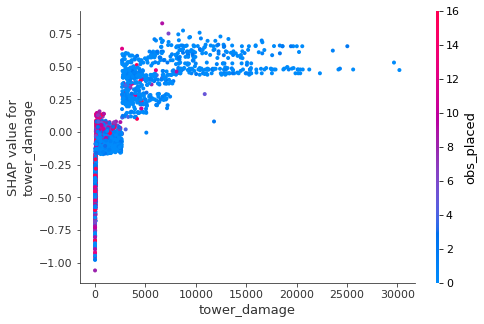

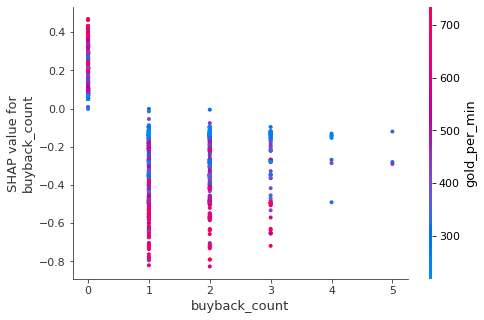

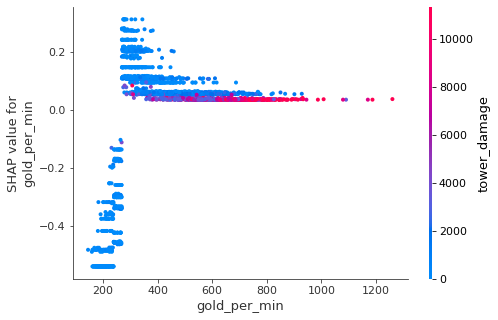

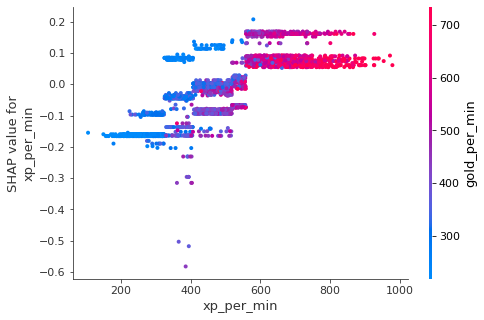

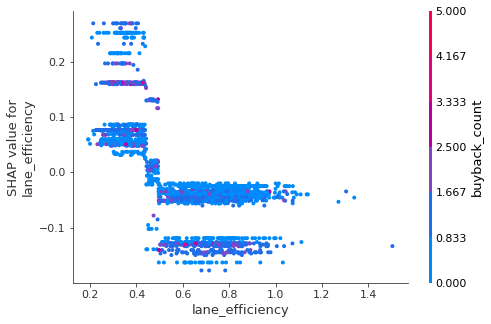

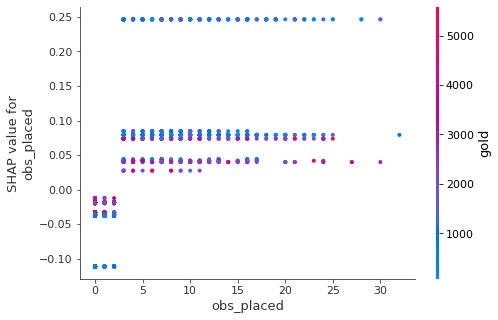

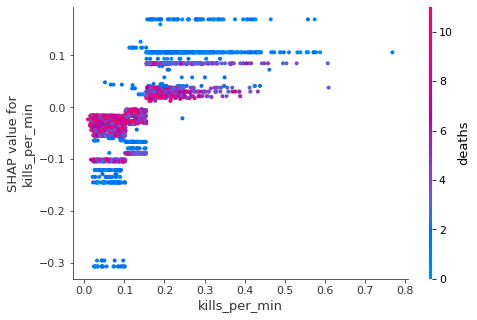

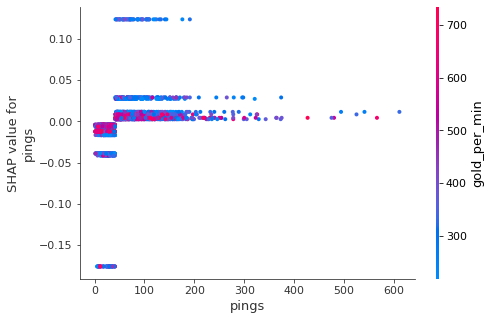

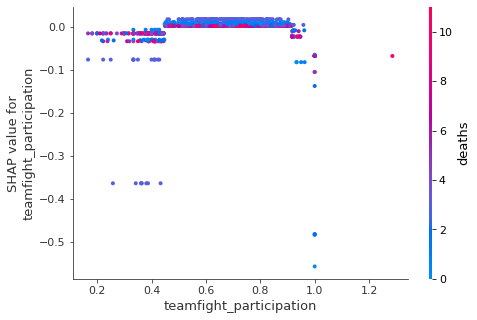

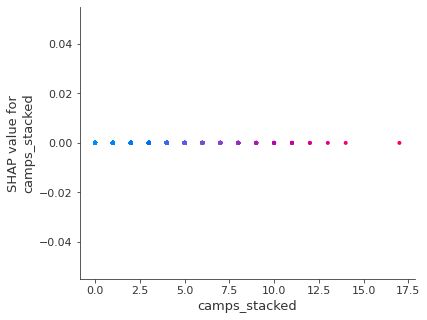

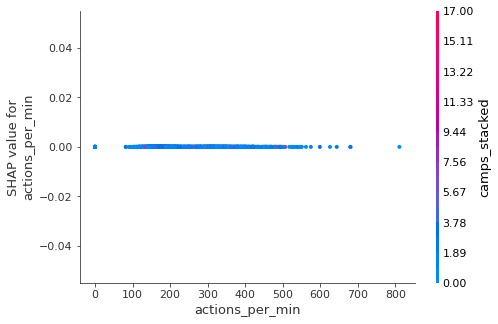

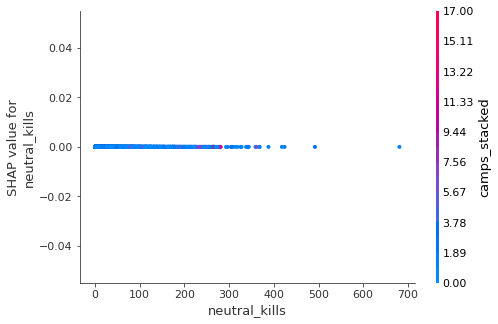

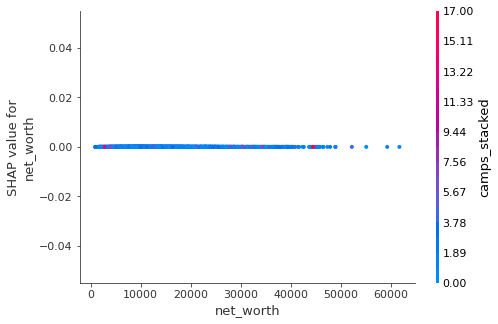

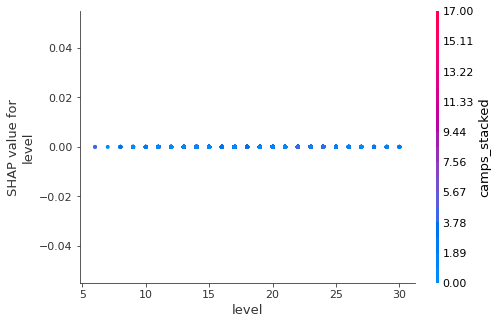

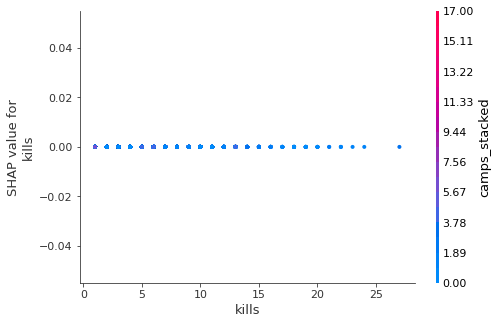

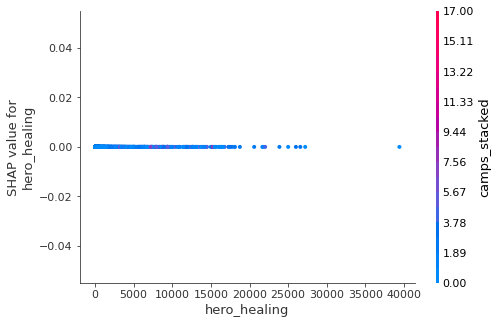

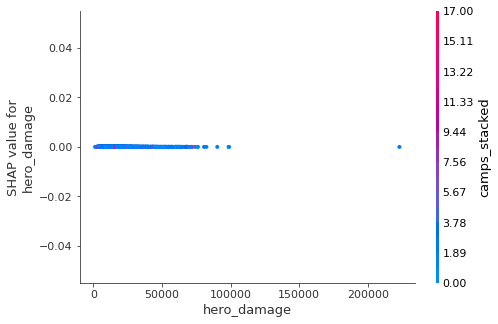

In [22]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, Xv)

## Conclusion

This was a fun project, I played more than 2k hours of Dota 2 I am a huge fan and wanted to do some experiment with Dota API

Explaning how a model works and behaves is a very important subject, maybe as important as the results of a prediction and SHAP is a powerfull tool to discover some great insights.

Speaking of insights, we end up with a trivial conclusion that the most important things to do in a match is: Get a lot of gold, dont die and be patient with buybacks!